We compare the performance of QFAMES with QMEGS: [Quantum 8, 1487 (2024).](https://quantum-journal.org/papers/q-2024-10-02-1487/)

In [ ]:
import scipy.linalg as la
from scipy.stats import truncnorm

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsfonts, amssymb, amsmath, physics}')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 12

import data_generator
import QFAMES

In [2]:
def generate_ts_distribution(T,N,sigma):
    """ Generate time samples from truncated Gaussian
    Input:

    T : variance of Gaussian
    sigma : truncated parameter
    N : number of samples

    Output:

    t_list: np.array of time points
    """
    np.random.seed(42)  #
    t_list=truncnorm.rvs(-sigma, sigma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,coefficient,T,N,sigma):
    """ Generate Z samples for a given T,N,sigma
    Input:

    spectrum: np.array of eigenvalues
    coefficient: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    sigma : truncated parameter

    Output:

    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,sigma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,coefficient,t_list,N_list)
    return Z_est, t_list, T_max, T_total

In [5]:
# Toy model spectrum
spectrum = np.array([0., 0., 0.1])

# Initial states
L=R=3
overlap=np.array([[1.,1.,1.],[1.,-1.,1.],[1.,1.,-1.]]) / np.sqrt(3)
coefficient=np.einsum('ik,jk->ijk',overlap,overlap)

N_rep=10 #number of different trying
spectrum_per=np.zeros((len(spectrum),N_rep))
for n in range(N_rep):
   spectrum_per[:,n]=spectrum+np.random.uniform(-1,1)*0.05

# Test QFAMES

In [7]:
T_list=np.array([40,50,60,80,100,200,400,800])
N=2000
K_QFAMES=4
K_dominant=3
alpha=5
sigma=1 #sigma is the truncation parameter
tau=0.1*np.sqrt(L*R)
Z_est=np.zeros((L,R,N),dtype='complex')
error_QFAMES=np.zeros(len(T_list),dtype='float') #store the eigenvalue estimation error
T_total_QFAMES=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    print('Running iteration',n+1,'of',N_rep)
    for k in range(len(T_list)):
        T_max=T_list[k]
        d_x=1*0.005/T_max
        for l in range(L):
            for r in range(R):
                Z_est[l,r,:],t_list, _, T_total = generate_Z(spectrum_per[:,n],coefficient[l,r,:],T_max,N,sigma)
        T_total_QFAMES[k]+=sum(np.abs(t_list))*9
        output_energy, output_num, output_vector= QFAMES.QFAMES(Z_est, d_x, t_list, K_QFAMES, alpha, T_max, tau, 'True')
        indices_to_delete = np.where(output_num<1)[0] #delete the noise part
        output_energy = np.delete(output_energy, indices_to_delete, axis=None)
        output_num = np.delete(output_num, indices_to_delete, axis=None)
        if len(output_energy) > 3:
           print('Ghost energy output:', output_energy[3:])
        if n==0:
            print('Tmax=',sigma*T_max)
            print('Output of QMEGS energy=',output_energy)
            print('Output of QMEGS number=',output_num)
        ##---measure error--##
        index_list=sorted(range(len(coefficient[0,0,:])),key= lambda k:coefficient[0,0,:][k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        # error_temp_vec=0
        for l in range(K_dominant):
                dominant_energy[l]=spectrum_per[index_list[l],n]
                error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        if n==0:
             print('energy_error=', error_temp)
        error_QFAMES[k] += error_temp
error_QFAMES = error_QFAMES / N_rep

Running iteration 1 of 10
Tmax= 40
Output of QMEGS energy= [0.01640735+0.j 0.11715735+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.002331651002425078
Tmax= 50
Output of QMEGS energy= [0.01500735+0.j 0.11340735+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.001418348997575633
Tmax= 60
Output of QMEGS energy= [0.01474068+0.j 0.11540735+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.0005816510024248267
Tmax= 80
Output of QMEGS energy= [0.01509485+0.j 0.11521985+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.0003941510024246392
Tmax= 100
Output of QMEGS energy= [0.01470735+0.j 0.11350735+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.001318348997575422
Tmax= 200
Output of QMEGS energy= [0.01490735+0.j 0.11485735+0.j]
Output of QMEGS number= [2 1]
energy_error= 8.165100242498585e-05
Tmax= 400
Output of QMEGS energy= [0.01461985+0.j 0.11475735+0.j]
Output of QMEGS number= [2 1]
energy_error= 0.00020584899757532076
Tmax= 800
Output of QMEGS energy= [0.01485735+0.j 0.1148

# Test QMEGS

In [7]:
T_list=np.array([40,50,60,80,100,200,400,800])
N=6000
K_QMEGS=4
K_dominant=3
alpha=5
sigma=1 #sigma is the truncation parameter
tau=0.1*np.sqrt(L*R)
Z_est=np.zeros((L,R,N),dtype='complex')
error_QMEGS=np.zeros(len(T_list),dtype='float') #store the eigenvalue estimation error
T_total_QMEGS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    print('Running iteration',n+1,'of',N_rep)
    for k in range(len(T_list)):
        T_max=T_list[k]
        d_x=1*0.005/T_max
        for l in range(L):
            for r in range(R):
                Z_est[l,r,:],t_list, _, T_total = generate_Z(spectrum_per[:,n],coefficient[l,r,:],T_max,N,sigma)
        T_total_QMEGS[k]+=sum(np.abs(t_list))*3
        Z_est_new=np.zeros((1,1,N),dtype='complex')
        Z_est_new[0,0,:] = (Z_est[0,0,:]+Z_est[1,1,:]+Z_est[2,2,:])/3
        output_energy, output_num, output_vector= QFAMES.QFAMES(Z_est_new,d_x, t_list, K_QMEGS, alpha, T_max, tau, 'True')
        indices_to_delete = np.where(output_num<1)[0] #delete the noise part
        output_energy = np.delete(output_energy, indices_to_delete, axis=None)
        output_num = np.delete(output_num, indices_to_delete, axis=None)
        if len(output_energy) > 3:
           print('Ghost energy output:', output_energy[3:])
        if n==0:
            print('Tmax=',sigma*T_max)
            print('Output of QMEGS energy=',output_energy)
            print('Output of QMEGS number=',output_num)
        ##---measure error--##
        index_list=sorted(range(len(coefficient[0,0,:])),key= lambda k:coefficient[0,0,:][k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K_dominant):
                dominant_energy[l]=spectrum_per[index_list[l],n]
                error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        if n==0:
             print('energy_error=', error_temp)
        error_QMEGS[k] += error_temp
error_QMEGS = error_QMEGS / N_rep

Running iteration 1 of 10
Tmax= 40
Output of QMEGS energy= [0.02440735+0.j]
Output of QMEGS number= [1]
energy_error= 0.08978399733405382
Tmax= 50
Output of QMEGS energy= [0.01320735+0.j]
Output of QMEGS number= [1]
energy_error= 0.10098399733405336
Tmax= 60
Output of QMEGS energy= [0.01132401+0.j 0.12632401+0.j]
Output of QMEGS number= [1 1]
energy_error= 0.012132669332613144
Tmax= 80
Output of QMEGS energy= [0.01478235+0.j 0.11346985+0.j]
Output of QMEGS number= [1 1]
energy_error= 0.0007214973340537029
Tmax= 100
Output of QMEGS energy= [0.01575735+0.j 0.10895735+0.j]
Output of QMEGS number= [1 1]
energy_error= 0.005233997334053428
Tmax= 200
Output of QMEGS energy= [0.01413235+0.j 0.11523235+0.j]
Output of QMEGS number= [1 1]
energy_error= 0.0010410026659462002
Tmax= 400
Output of QMEGS energy= [0.01395735+0.j 0.11414485+0.j]
Output of QMEGS number= [1 1]
energy_error= 0.0002339973340536334
Tmax= 800
Output of QMEGS energy= [0.0142261+0.j 0.1141011+0.j]
Output of QMEGS number= [1 1]


In [8]:
print(T_list)
print(error_QFAMES)
print(error_QMEGS)
print( np.dot(error_QFAMES,T_list)/T_list/len(error_QFAMES))

[ 40  50  60  80 100 200 400 800]
[2.40182744e-03 1.52904834e-03 1.27211620e-03 6.13702118e-04
 9.38683727e-04 2.06922601e-04 1.43724151e-04 6.35775111e-05]
[8.99981726e-02 1.01600673e-01 2.06562596e-02 1.17942256e-03
 4.34806726e-02 7.00463306e-04 1.91922556e-04 8.22519779e-05]
[1.69235381e-03 1.35388305e-03 1.12823587e-03 8.46176904e-04
 6.76941523e-04 3.38470762e-04 1.69235381e-04 8.46176904e-05]


In [ ]:
plt.figure(figsize=(5, 3.5))
plt.plot(T_list, error_QFAMES, marker="*",markersize=5,
           lw=1, label='Error of QFAMES')
plt.plot(T_list, error_QMEGS, marker="o",markersize=5,
           lw=1, label='Error of QMEGS')
plt.plot(T_list, np.dot(error_QFAMES,T_list)/T_list/len(error_QFAMES), ls ='--', lw=1, label=r'$T^{-1}$')
plt.xlabel(r'$T_{\max}$',fontsize=12)
plt.ylabel(r'Error',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.savefig('figs/err_T_max.pdf', bbox_inches='tight')
plt.close()

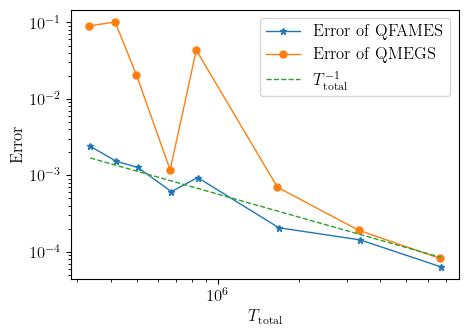

In [ ]:
T_total_QFAMES = T_total_QFAMES / N_rep
T_total_QMEGS = T_total_QMEGS / N_rep
plt.figure(figsize=(5, 3.5))
plt.plot(T_total_QFAMES, error_QFAMES, marker="*",markersize=5,
           linewidth=1, label='Error of QFAMES')
plt.plot(T_total_QMEGS, error_QMEGS, marker="o",markersize=5,
           linewidth=1, label='Error of QMEGS')
plt.plot(T_total_QFAMES, np.dot(error_QFAMES,T_total_QFAMES)/T_total_QFAMES/len(error_QFAMES),
           '--', linewidth=1, label=r'$T_{\mathrm{total}}^{-1}$')
plt.xlabel(r'$T_{\mathrm{total}}$',fontsize=12)
plt.ylabel("Error",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.savefig('fig/err_T_total.pdf', bbox_inches='tight')